# Simple RL code to teach the model to stand

## Setup jax enviroment and Load Model 

In [1]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

import sys
sys.path.append("../Biodiffrl")

import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".60"

# Optionally, force JAX to preallocate memory.
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    # '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    # '--xla_gpu_enable_async_collectives=true '
    # '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
    # '--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32'
)

backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
jax.config.update('jax_platform_name', 'gpu')
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_lazy_compilation=false"
# Enable compliation catch
os.environ["JAX_COMPILATION_CACHE_DIR"] = "./jax_cache"
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 2)
# jax.config.update("jax_explain_cache_misses", True)

from jax.experimental.compilation_cache import compilation_cache as cc
cc.set_cache_dir("./jax_cache")
# Debug Nan
# jax.config.update("jax_debug_nans", True)

from jax import numpy as jp
# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '/home/bugman/Currentwork/biomujoco_converter/converted/mjc/Gait2354/gait2354_cvt1.xml'

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)



# mjx_multiple_steps = jax.jit(multiple_steps, backend=backend, )

## Load Model

In [2]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = jax.jit(mjx_step)(mjx_model, mjx_data)

init_mjx_data = mjx_data

def print_all():
    print(mjx_model.biomtu_adr)
    print(mjx_model.mtu_wrap_objid)
    print(mjx_model.mtu_wrap_type)
    print(mjx_model.biomtu_fiso)
    print(mjx_model.biomtu_vmax)
    print(mjx_model.biomtu_ofl)
    print(mjx_model.biomtu_opa)
    print(mjx_model.biomtu_mass)
    print("-------Data--------")
    print("qpos:", mjx_data.qpos)
    print("mtu l:", mjx_data.biomtu.l)
    print("tendon l:", mjx_data.biomtu.tendon_l)
    print("fiber l :", mjx_data.biomtu.fiber_l)
    print("Muscle Bce:", mjx_data.biomtu.B_ce)
    print("Muscle vm:", mjx_data.biomtu.m)
    print("Fiber acc:", mjx_data.biomtu.fiber_acc)
    print("Fiber v:", mjx_data.biomtu.fiber_v)
    print("Biomtu h:", mjx_data.biomtu.h)
    print(mjx_data.biomtu.v)
    print(mjx_data.biomtu.h)  # The constant high of the muscle.
    print(mjx_data.biomtu.pennation_angle)
    print(mjx_data.biomtu.origin_body_id)
    print(mjx_data.biomtu.insertion_body_id)
    print("mtu act:", mjx_data.biomtu.act)
    # print(mjx_data.biomtu.j)
    print(mjx_data.qfrc_biomtu)
    print(mj_model.key_time)
    print(mj_model.key_qpos)
    print(mj_model.key_qvel)

# print_all()

print(mjx_model.nbiomtu)
print(mjx_model.nq)
print(mjx_data.qpos)
print(mjx_data.qvel)

54
27
[ 0.      0.9501  0.      0.0006  0.     -0.     -0.0013 -0.     -0.0009 -0.0037 -0.3957  0.0023
 -0.0199 -0.0032  0.0228 -0.0013 -0.     -0.0009 -0.0037 -0.3957  0.0023 -0.0199 -0.0032  0.0228
 -0.0007 -0.      0.    ]
[ 0.0149  0.0271  0.      0.3064  0.     -0.     -0.6693 -0.0194 -0.4365 -0.0074  0.0056  1.1327
 -9.9627 -1.625  11.377  -0.6693 -0.0194 -0.4365 -0.0074  0.0056  1.1327 -9.9628 -1.625  11.377
 -0.3256 -0.      0.    ]


## Neural Networks

In [3]:
import nn

key = jax.random.key(2024)
# Controller NN
controller_nn = nn.Controller_NN(mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu)
controller_params, key = controller_nn.init_parameters(key)
controller = controller_nn.get_fn()

# Critic NN
critic_nn = nn.Critic_NN(mjx_model.nq*2 + mjx_model.nbiomtu*2,1)
critic_params, key = critic_nn.init_parameters(key)
criticer = critic_nn.get_fn()

# Test the two neural networks
controller_output = controller(controller_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2), key)
print(controller_output[0].shape)
print(controller_output)
print(criticer(critic_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2)))

(54,)
(Array([0.0971, 0.    , 0.0322, 0.2231, 0.    , 0.2458, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.1534, 0.1996, 0.    , 0.    , 0.    , 0.1441, 0.2597, 0.    , 0.    ,
       0.2615, 0.    , 0.4346, 0.5389, 0.    , 0.    , 0.0718, 0.    , 0.3151, 0.3023, 0.    ,
       0.    , 0.082 , 0.3204, 0.1442, 0.    , 0.    , 0.0949, 0.    , 0.    , 0.0724, 0.6084,
       0.    , 0.248 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1358, 0.    , 0.    ],      dtype=float32), Array([0.2006, 0.0239, 0.1653, 0.3102, 0.    , 0.3476, 0.    , 0.    , 0.0396, 0.    , 0.    ,
       0.    , 0.    , 0.2458, 0.2882, 0.    , 0.    , 0.    , 0.2859, 0.346 , 0.    , 0.    ,
       0.3306, 0.    , 0.5448, 0.6572, 0.    , 0.0215, 0.1492, 0.    , 0.4006, 0.3831, 0.    ,
       0.    , 0.2316, 0.3897, 0.2437, 0.    , 0.    , 0.2122, 0.    , 0.    , 0.1918, 0.6812,
       0.    , 0.2966, 0.    , 0.    , 0.    , 0.0958, 0.    , 0.284 , 0.    , 0.    ],      dtype=float32), Array([ 0.0455,

## Environment Control

In [4]:
from functools import partial
# Since the environment resets with init_mjx_data, the muscles are already in the equilibrum condition.
def reset(init_mjx_data, batch_size):
    new_data = jax.tree.map(
        partial(jp.repeat, repeats=batch_size, axis=0),
        jax.tree.map(partial(jp.expand_dims, axis=0),init_mjx_data))
    return new_data

def random_init(data, model, rng: jax.Array):
    nbiomtu = model.nq
    init_qpos = data.qpos
    init_qvel = data.qvel
    new_rng, rng1, rng2 = jax.random.split(rng, 3)
    # Qpos_1 is the vertical position
    random_qpos = init_qpos + jax.random.uniform(rng1, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    random_qvel = init_qvel + jax.random.uniform(rng2, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    newdata = data.replace(qpos=random_qpos)
    newdata = newdata.replace(qvel=random_qvel)
    newdata = mjx.forward(mjx_model, newdata)
    # print('data:',data.qpos, data.qvel)
    # Calculate equilibrum
    # newdata = acceleration_mtu.calc_equilibrium(mjx_model, newdata)
    # newdata = mjx_step(mjx_model, newdata)
    return newdata, new_rng

vrandom_init = jax.jit(jax.vmap(random_init, in_axes=(None, None, 0), out_axes=0))
    

## Multi-steps forward simulation

In [ ]:
import exp

# Multiple steps
def step_fn(carry, _):
    model, data= carry
    new_data = mjx.step(model, data)
    new_carry = (model, new_data)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (model, data)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[0]
    return new_data

# For one step
def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

def nn_mjx_perturbe_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    xfrc = jax.random.normal(key,(mjx_model.nbody, 6))*1.0
    data = data.replace(xfrc_applied=xfrc)
    new_data = mjx.step(model, data)
    return new_data, new_key, act

@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    # new_data, new_key, act = nn_mjx_perturbe_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    head_hight = new_data.sensordata[2]
    state = jp.concat([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    next_state = jp.concat([new_data.qpos, new_data.qvel, new_data.biomtu.fiber_l, new_data.biomtu.fiber_v])
    action = act
    reward = -(head_hight-1.63)**4
    done = head_hight < 1.0
    experience = exp.experience(state, next_state, action, reward, done)
    
    return new_carry, experience

@jax.jit
def nn_multi_steps(nn_params, model, data, key):
    # Also deal with the done in the experience pool
    
    repeat_length = 50  # Simulate for 0.1s
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    return new_data, new_key, experience

jit_nn_multi_steps = jax.jit(nn_multi_steps)

# @jax.jit
def v_nn_multi_steps(nn_params, model, data, keys):
    return jax.vmap(nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, keys)

jit_v_nn_multi_steps = jax.jit(v_nn_multi_steps)




In [6]:
# Settings
import exp

critic_batch_size = 64*10
controller_batch_size = 64
key = jax.random.key(2024)
keys = jax.random.split(key, controller_batch_size)

memory_settings = exp.memory_settings(critic_batch_size*126, mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu, 1)

### Generate initial experience

In [7]:
exp_pool = None
datas = jax.jit(reset,static_argnames="batch_size")(init_mjx_data, controller_batch_size)
init_data_batch = datas
for i in range(5):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
print(exp_pool.states.shape)

(16000, 162)


## Prepare Critic gradient

In [8]:
import optax

v_criticer = jax.vmap(criticer,in_axes=(None, 0))
jit_v_criticer = jax.jit(v_criticer)

def critic_loss(params, batch):
    discount = 0.95
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_criticer(params, states)
    # target = rewards + discount* jax.lax.stop_gradient(v_criticer(params, next_states))
    target = rewards + discount* (v_criticer(params, next_states))
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss

sample_batch = exp.memory.sample(exp_pool, critic_batch_size, key)
critic_loss_g_value_lower= jax.jit(jax.value_and_grad(critic_loss)).lower(critic_params, sample_batch)

jit_critic_loss_g_value = critic_loss_g_value_lower.compile()
a=jit_critic_loss_g_value.cost_analysis()[0]['flops']
print(a)

19671028.0


## Prepare Actor gradient

In [ ]:
def controller_loss_and_experience(controller_params, critic_params, batch, batch_size, mjx_model, init_data_batch, keys):
    # Generate data for simulation
    nq = mjx_model.nq
    nmtu = mjx_model.nbiomtu
    
    # Deal with the done state, reset the done state with init state
    # exp_data_batch = init_data_batch.replace(
    #     qpos = batch.states[:,0:nq], 
    #     qvel = batch.states[:,nq:nq*2],
    #     biomtu = init_data_batch.biomtu.replace(
    #         fiber_l = batch.states[nq*2, nq*2+nmtu],
    #         fiber_v = batch.states[nq*2+nmtu, nq*2+nmtu*2]
    #     ))
    
    qpos = jp.where(batch.dones, init_data_batch.qpos, batch.states[:,0:nq])
    qvel = jp.where(batch.dones, init_data_batch.qvel, batch.states[:,nq:nq*2])
    fiber_l = jp.where(batch.dones, init_data_batch.biomtu.fiber_l, batch.states[:,nq*2 : nq*2+nmtu])
    fiber_v = jp.where(batch.dones, init_data_batch.biomtu.fiber_v, batch.states[:,nq*2+nmtu : nq*2+nmtu*2])
    
    # in_data = batch.dones, init_data_batch, exp_data_batch)
    
    in_data = jax.lax.stop_gradient(init_data_batch.replace(
        qpos = qpos,
        qvel = qvel,
        biomtu = init_data_batch.biomtu.replace(
            fiber_l = fiber_l,
            fiber_v = fiber_v)
        )
    )
    
    out_data, keys, new_exps = v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    # out_states = jp.concat([out_data.qpos, out_data.qvel],axis=1).reshape(batch_size,4)
    out_states = new_exps.next_states
    # jax.debug.print("out_states shape{0}", out_states.shape)
    # out_states = jp.concat([out_data.qpos, out_data.qvel, out_data.biomtu.fiber_l, out_data.biomtu.fiber_v],axis=1)
    critic_score = v_criticer(critic_params, out_states)
    
    loss = -jp.mean(critic_score)
    return loss, new_exps

# The function calculating the loss of the controller and also generate experiences
g_loss_experience = jax.value_and_grad(controller_loss_and_experience, has_aux=True)

controller_keys = jax.random.split(key, controller_batch_size)
sample_batch = exp.memory.sample(exp_pool, controller_batch_size, key)

print("lowering")
g_loss_experience_lower = jax.jit(g_loss_experience, static_argnames=["batch_size"]).lower(
    controller_params, 
    critic_params, 
    sample_batch, 
    controller_batch_size, 
    mjx_model, 
    init_data_batch, 
    controller_keys)

print("compiling")
jit_g_loss_experience = g_loss_experience_lower.compile()

b = jit_g_loss_experience.cost_analysis()[0]['flops']
print(b)

lowering


In [ ]:
print(sample_batch.states.shape)
print(b/a)

(64, 162)
14.231017328242551


## Train the two neural networks

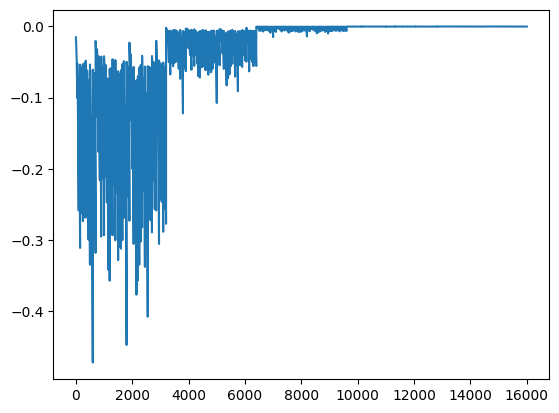

In [ ]:
key = jax.random.key(9687658)
keys = jax.random.split(key, controller_batch_size)

critic_params, key = critic_nn.init_parameters(key)
critic_tx = optax.apply_if_finite(optax.adam(learning_rate=5e-5), max_consecutive_errors=50)
# critic_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-4), max_consecutive_errors=50)
critic_opt_state = critic_tx.init(critic_params)
jit_critic_tx_update = jax.jit(critic_tx.update)


controller_params, key = controller_nn.init_parameters(key)
controller_tx = optax.apply_if_finite(optax.adam(learning_rate=1e-5), max_consecutive_errors=50)
# controller_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-4), max_consecutive_errors=50)
controller_opt_state = controller_tx.init(controller_params)
jit_controller_tx_update = jax.jit(controller_tx.update)

jit_apply_update = jax.jit(optax.apply_updates)


jit_sample = jax.jit(exp.memory.sample, static_argnames="batch_size")
jit_add_exp = jax.jit(exp.memory.add_exp, static_argnames="settings")

# Init exp_pool
exp_pool = None
datas = reset(init_mjx_data,controller_batch_size)
for i in range(5):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)

#plot exp_pool
# plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)

In [ ]:
# Debug Nan
# jax.config.update("jax_debug_nans", True)

import exp


death_rate_buf = []
best_death_rate = 0.5

for i in range(4000):

    print("----------",i,"----------")
    
    criric_repeat = 16
    if(i == 500):
        criric_repeat = 1
        
    for j in range(criric_repeat):
        batch = jit_sample(exp_pool, critic_batch_size, key)
        key = jax.random.split(key, 1)[0]
        
        # criticer
        critic_loss, critic_loss_grad = jit_critic_loss_g_value(critic_params, batch)
        
        # Update params
        critic_updates, critic_opt_state = jit_critic_tx_update(critic_loss_grad, critic_opt_state)
        critic_params = jit_apply_update(critic_params, critic_updates)
    
    print("criticer loss:",critic_loss)
    # controller
    
    # for j in range(3):
    keys = jax.random.split(key,controller_batch_size)
    controller_batch = jit_sample(exp_pool, controller_batch_size, key)
    key = jax.random.split(key, 1)[0]
    controller_loss_exps, controller_loss_grad = jit_g_loss_experience(
        controller_params, critic_params, controller_batch, mjx_model, init_data_batch, keys)
    controller_loss = controller_loss_exps[0]
    exps = controller_loss_exps[1]
        
    # Update params
    controller_updates, controller_opt_state = jit_controller_tx_update(controller_loss_grad, controller_opt_state)
    controller_params = jit_apply_update(controller_params, controller_updates)
    
    exp_pool = jit_add_exp(memory_settings, exp_pool, exps)
    
    # Count Dones
    death_rate_buf.insert(0, jp.count_nonzero( exps.dones)/(exps.dones.shape[1]*controller_batch_size))
    death_rate_buf = death_rate_buf[:50]
    death_rate = np.mean(death_rate_buf)
    
    print("Controller Loss:", controller_loss)
    mean_reward = jp.mean(exps.rewards)
    print("mean rewards:", mean_reward)
    mean_score = jp.mean(jit_v_criticer(critic_params, exps.states))
    print("mean score:", mean_score)
    print("scorc/reward:", mean_score/mean_reward)
    print("death rate:", death_rate)
    
    if(best_death_rate > death_rate): best_death_rate = death_rate
    print("best_death_rate:", best_death_rate)
    # add exps
    
    if(i%20 == 0):
        plt.figure()
        plt.plot(exp_pool.rewards)
        plt.plot()
        # plt.plot(exp_pool.rewards)

---------- 0 ----------
criticer loss: 5.9387717e-06
Controller Loss: 0.77531797
mean rewards: -0.02297978
mean score: -0.5856105
scorc/reward: 25.483732
death rate: 0.125625
best_death_rate: 0.125625
---------- 1 ----------
criticer loss: 7.95932e-06
Controller Loss: 0.63879776
mean rewards: -0.017743152
mean score: -0.47317696
scorc/reward: 26.668146
death rate: 0.086406246
best_death_rate: 0.086406246
---------- 2 ----------
criticer loss: 7.472419e-06
Controller Loss: 0.7740769
mean rewards: -0.021281201
mean score: -0.5679113
scorc/reward: 26.686056
death rate: 0.079791665
best_death_rate: 0.079791665
---------- 3 ----------
criticer loss: 6.5656336e-06
Controller Loss: 0.8111665
mean rewards: -0.025251016
mean score: -0.6340526
scorc/reward: 25.109983
death rate: 0.0990625
best_death_rate: 0.079791665
---------- 4 ----------
criticer loss: 8.35774e-06
Controller Loss: 0.6620053
mean rewards: -0.018547948
mean score: -0.49057743
scorc/reward: 26.449148
death rate: 0.089687504
best

## Visualize the model and controller

In [15]:
import mujoco.viewer
import time


# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)

previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        
        # Generate key
        key = jax.random.split(key,1)[0]
        # xfrc = jax.random.uniform(key,(mjx_model.nbody, 6), minval=-10, maxval=10)
        # mjx_data = mjx_data.replace(xfrc_applied=xfrc)
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, exps = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mj_data.sen)  
        print(mjx_data.sensordata[2])
        print(mjx_data.biomtu.act)
        # print(len(mjx_data.qvel))
        viewer.sync()

Time between frames: 0.27426934242248535 seconds
1.6315
[0.2049 0.0321 0.02   0.0467 0.1199 0.     0.0661 0.1498 0.1049 0.0522 0.0765 0.0294 0.     0.1845
 0.     0.0231 0.     0.     0.2118 0.1251 0.0335 0.0923 0.0635 0.1254 0.0649 0.0332 0.1646 0.0165
 0.0548 0.236  0.0285 0.1048 0.093  0.     0.0722 0.0639 0.     0.1868 0.1742 0.0177 0.1045 0.1211
 0.1452 0.1005 0.1205 0.0414 0.0511 0.2383 0.0577 0.2007 0.2504 0.0454 0.0662 0.    ]
Time between frames: 0.01840066909790039 seconds
1.6314938
[1.59   0.     0.     0.     0.9138 0.     0.2326 1.3852 0.8266 0.     0.     0.     0.     1.3256
 0.     0.     0.     0.     1.9147 0.5231 0.     0.5999 0.537  2.0199 0.     0.3192 0.7298 0.
 0.     2.077  0.     0.4163 0.0327 0.     1.2395 0.9497 0.     1.3163 1.1772 0.     1.2699 0.7155
 1.8581 0.0926 0.3105 0.     0.     1.1619 0.193  3.3191 3.7289 0.     0.     0.    ]
Time between frames: 0.016399621963500977 seconds
1.6314988
[1.5108 0.     0.     0.     0.0407 0.     0.     1.6049 0.6649